## Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

!wget https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf  
!pip install -q -U sentence-transformers

from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Komoran, Okt, Kkma, Hannanum
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

--2022-06-14 16:43:01--  https://github.com/kairess/MBTI-wordcloud/raw/master/NanumSquareRoundR.ttf
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf [following]
--2022-06-14 16:43:01--  https://raw.githubusercontent.com/kairess/MBTI-wordcloud/master/NanumSquareRoundR.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063276 (1.0M) [application/octet-stream]
Saving to: ‘NanumSquareRoundR.ttf.7’

NanumSquareRoundR.t 100%[===================>]   1.01M  --.-KB/s    in 0.04s   

2022-06-14 16:43:01 (25.8 MB/s) - ‘NanumSquareRoundR.ttf.7’ saved 

## Data file

In [2]:
chatbot_data = pd.read_csv("/aiffel/aiffel/transformer_chatbot/data/chatbotdata.csv", sep = ',')
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Preprocessing

In [3]:
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

In [5]:
preprocess_sentence(chatbot_data['Q'][0])

'12시 땡 !'

In [6]:
inputs, outputs = [], []
for questions, answers in zip(chatbot_data['Q'], chatbot_data['A']):
    
    inputs.append(preprocess_sentence(questions))
    outputs.append(preprocess_sentence(answers))

In [7]:
print('전체 샘플 수 :', len(inputs))
print('전체 샘플 수 :', len(outputs))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(inputs[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(outputs[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## Word cloud

### Question word cloud

In [9]:
extractor = Hannanum()

nouns = []

for review in tqdm(chatbot_data['Q'].values.tolist()):
    nouns.extend(extractor.nouns(review))

print(f'질문의 명사 갯수 : {len(nouns)}')

100%|██████████| 11823/11823 [00:11<00:00, 1004.17it/s]

질문의 명사 갯수 : 23228


In [10]:
count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

것 856
나 814
사람 629
사랑 365
이별 310
연락 240
뭐 232
여자친구 218
오늘 217
남자친구 197
친구 193


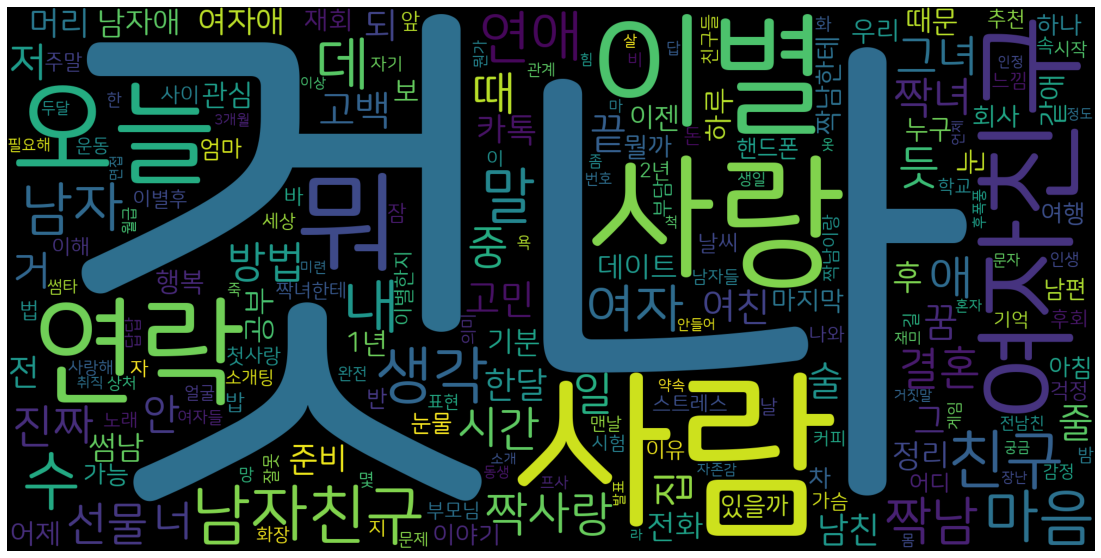

In [11]:
wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

### Answer word cloud

In [12]:
extractor = Hannanum()

nouns = []

for review in tqdm(chatbot_data['A'].values.tolist()):
    nouns.extend(extractor.nouns(review))

print(f'답변의 명사 갯수 : {len(nouns)}')

100%|██████████| 11823/11823 [00:13<00:00, 868.58it/s]

답변의 명사 갯수 : 23092


In [13]:
count = Counter(nouns)
words = dict(count.most_common())

for i, (word, count) in enumerate(words.items()):
    if i > 10:
        break

    print(word, count)

것 1108
거예요 1043
수 710
사람 530
생각 521
마음 485
사랑 463
저 372
거 346
시간 279
말 279


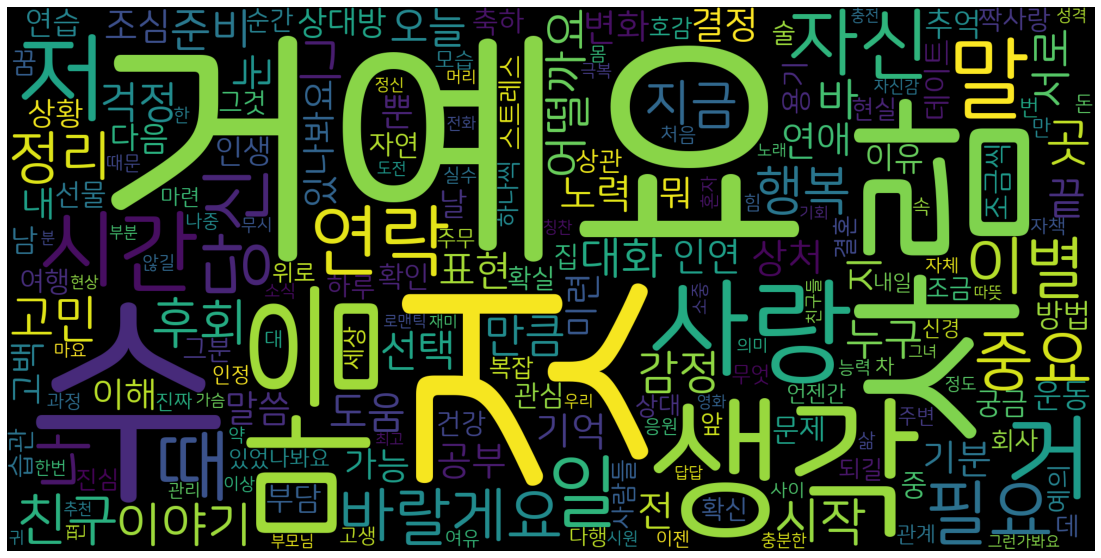

In [14]:
wc = WordCloud(
    font_path='NanumSquareRoundR.ttf',
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')
plt.show()

## 토큰화 함수 정의 (Tokenizer)

#### SubwordTextEncoder 
- 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 **정수로 인코딩**

In [15]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)

INFO:absl:SubwordTextEncoder build: trying min_token_count 6694
INFO:absl:SubwordTextEncoder build: trying min_token_count 3347
INFO:absl:SubwordTextEncoder build: trying min_token_count 1673
INFO:absl:SubwordTextEncoder build: trying min_token_count 836
INFO:absl:SubwordTextEncoder build: trying min_token_count 418
INFO:absl:SubwordTextEncoder build: trying min_token_count 209
INFO:absl:SubwordTextEncoder build: trying min_token_count 104
INFO:absl:SubwordTextEncoder build: trying min_token_count 52
INFO:absl:SubwordTextEncoder build: trying min_token_count 26
INFO:absl:SubwordTextEncoder build: trying min_token_count 13
INFO:absl:SubwordTextEncoder build: trying min_token_count 6
INFO:absl:SubwordTextEncoder build: trying min_token_count 3
INFO:absl:SubwordTextEncoder build: trying min_token_count 4


In [16]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [17]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [18]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [19]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(inputs[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(outputs[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [20]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


## Encoder - decoder

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [26]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [28]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Transformer

In [32]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Hyperparameter tuning

In [33]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5255424     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## Teacher Forcing

In [34]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [38]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 44s 114ms/step - loss: 1.4402 - accuracy: 0.0218
Epoch 2/50
185/185 [==============================] - 21s 115ms/step - loss: 1.1857 - accuracy: 0.0441
Epoch 3/50
185/185 [==============================] - 21s 115ms/step - loss: 1.0200 - accuracy: 0.0500
Epoch 4/50
185/185 [==============================] - 22s 116ms/step - loss: 0.9535 - accuracy: 0.0519
Epoch 5/50
185/185 [==============================] - 21s 114ms/step - loss: 0.9168 - accuracy: 0.0543
Epoch 6/50
185/185 [==============================] - 21s 115ms/step - loss: 0.8852 - accuracy: 0.0556
Epoch 7/50
185/185 [==============================] - 21s 116ms/step - loss: 0.8528 - accuracy: 0.0574
Epoch 8/50
185/185 [==============================] - 21s 114ms/step - loss: 0.8192 - accuracy: 0.0591
Epoch 9/50
185/185 [==============================] - 21s 114ms/step - loss: 0.7825 - accuracy: 0.0610
Epoch 10/50
185/185 [==============================] - 21s 114ms/step - l

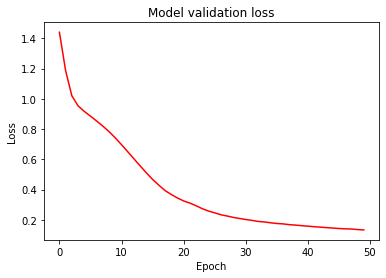

In [39]:
plt.plot(history.history['loss'], 'r')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [40]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [41]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [42]:
sentence_generation("너 이름이 뭐니?")

입력 : 너 이름이 뭐니?
출력 : 저도 데려가세요 .


'저도 데려가세요 .'

In [43]:
sentence_generation("나 너 좋아하냐?")

입력 : 나 너 좋아하냐?
출력 : 당신을 이끌어주는 남자를 만날 수 있을 거예요 .


'당신을 이끌어주는 남자를 만날 수 있을 거예요 .'

In [44]:
sentence_generation("보일 듯 보이지 않아~")

입력 : 보일 듯 보이지 않아~
출력 : 마음이 복잡한가봐요 .


'마음이 복잡한가봐요 .'

In [45]:
sentence_generation("사랑해")

입력 : 사랑해
출력 : 몸과 마음이 좀 쉬어야 할 것 같아요 .


'몸과 마음이 좀 쉬어야 할 것 같아요 .'

In [46]:
sentence_generation("똑바로 대답해")

입력 : 똑바로 대답해
출력 : 잘 생각해보세요 .


'잘 생각해보세요 .'

## SentenceBERT

In [47]:
model = SentenceTransformer('jhgan/ko-sroberta-multitask')

In [48]:
print(chatbot_data.shape)
df = chatbot_data[~chatbot_data['A'].isna()]

print(df.shape)

(11823, 3)
(11823, 3)


In [49]:
df['embedding'] = pd.Series([[]] * len(df)) # dummy

df['embedding'] = df['Q'].map(lambda x: list(model.encode(x)))

df.head()

,Q,A,label,embedding
0,12시 땡!,하루가 또 가네요.,0,"[-0.19072694, 0.32147554, 0.5987379, 0.4461785..."
1,1지망 학교 떨어졌어,위로해 드립니다.,0,"[0.12320561, 0.64236814, 0.68536, -0.4291239, ..."
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,"[0.024357779, -0.22393532, 0.22917686, -0.4501..."
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,"[0.036285497, -0.21048248, 0.072694026, -0.540..."
4,PPL 심하네,눈살이 찌푸려지죠.,0,"[0.022030337, 0.7055218, -0.17157197, 0.165972..."


In [51]:
text1 = '요즘 머리가 아프고 너무 힘들어'

embedding = model.encode(text1)

In [52]:
df['distance'] = df['embedding'].map(lambda x: cosine_similarity([embedding], [x]).squeeze())

df.head()

,Q,A,label,embedding,distance
0,12시 땡!,하루가 또 가네요.,0,"[-0.19072694, 0.32147554, 0.5987379, 0.4461785...",0.119280
1,1지망 학교 떨어졌어,위로해 드립니다.,0,"[0.12320561, 0.64236814, 0.68536, -0.4291239, ...",0.166556
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,"[0.024357779, -0.22393532, 0.22917686, -0.4501...",0.184115
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,"[0.036285497, -0.21048248, 0.072694026, -0.540...",0.155155
4,PPL 심하네,눈살이 찌푸려지죠.,0,"[0.022030337, 0.7055218, -0.17157197, 0.165972...",0.224952


In [54]:
answer = df.loc[df['distance'].idxmax()]

print('입력 : ', text1)
print('출력 : ', answer['A'])
print('입력과 질문의 유사도', answer['distance'])

입력 :  요즘 머리가 아프고 너무 힘들어
출력 :  시원한 바람 쉬고 약먹기!
입력과 질문의 유사도 0.9030821919441223


### Functionalization

In [55]:
def sentence_generation_2(text):
    embedding = model.encode(text)
    df['distance'] = df['embedding'].map(lambda x: cosine_similarity([embedding], [x]).squeeze())
    answer = df.loc[df['distance'].idxmax()]

    print('입력 : ', text)
    print('출력 : ', answer['A'])
    print()
    print(answer["A"])
    #print(f'입력과 질문의 유사도 answer['distance']')

In [56]:
sentence_generation_2('너 이름이 뭐니?')

입력 :  너 이름이 뭐니?
출력 :  위로봇이요.

위로봇이요.


In [57]:
sentence_generation_2('나 너 좋아하냐?')

입력 :  나 너 좋아하냐?
출력 :  긴가민가한 상태인가봅니다.

긴가민가한 상태인가봅니다.


In [58]:
sentence_generation_2('보일 듯 보이지 않아~')

입력 :  보일 듯 보이지 않아~
출력 :  모든 일이 뜻대로 흘러가진 않으니까요.

모든 일이 뜻대로 흘러가진 않으니까요.


In [59]:
sentence_generation_2('사랑해')

입력 :  사랑해
출력 :  상대방에게 전해보세요.

상대방에게 전해보세요.


In [60]:
sentence_generation_2('똑바로 대답해')

입력 :  똑바로 대답해
출력 :  노력하고 있어요.

노력하고 있어요.


## Discussion

1. 한국어 전처리를 통해 학습 데이터셋을 구축  
 **공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정을 적절히 진행**  
  
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행  
 **구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴**  
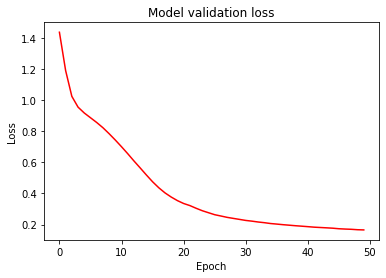
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
 **한국어 입력문장에 그럴듯한 한국어로 답변을 리턴**  
 **특히나 sentenceBERT 모델을 사용했을 떄, 훨씬 더 그럴듯한 문장 리턴**
<table>
    <tr>
        <td>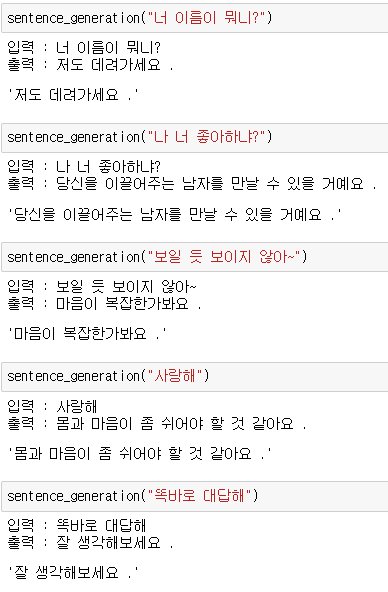</td><td>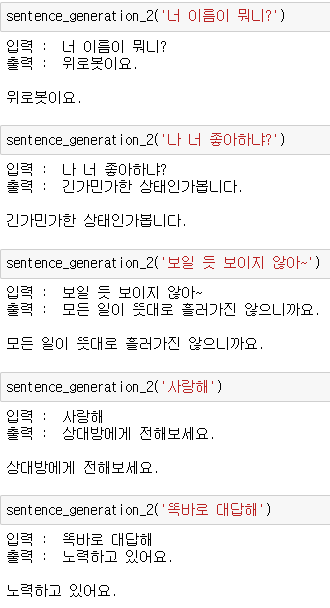</td>
    </tr>    
</table>


## Reference

1. https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2021.%20%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EB%A1%9C%20%EB%A7%8C%EB%93%9C%EB%8A%94%20%EB%8C%80%ED%99%94%ED%98%95%20%EC%B1%97%EB%B4%87.ipynb
2. https://github.com/PEBpung/Aiffel/blob/master/Project/Exploration/E21.Make_Chatbot_using_Transformer.ipynb
3. https://www.youtube.com/watch?v=VVArHrsxrYU
4. https://www.youtube.com/watch?v=AA621UofTUA
5. https://github.com/kairess/mental-health-chatbot/blob/master/simple_chatbot.ipynb